Code to process data for and plot Figures 3 and S2 from Siegfried\*, Venturelli\*, et al. (2023)

This notebook also estimates the mean and standard deviation lake sediment thickness as well as the <br>
age distribution of Mercer Subglacial Lake, West Antarctica

Email siegfried@mines.edu, venturelli@mines.edu, warnuk1@binghamton.edu, and patterso@binghamton.edu with any questions

In [1]:
%load_ext rpy2.ipython

from pydicom import dcmread
import matplotlib.pyplot as plt
import seaborn as sns
import pygmt 
                 
import pandas as pd
import numpy as np
from glob import glob
import time
import random
import skimage.segmentation as seg
from scipy import optimize

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

In [2]:
%%R

# Load the sedimentation rate results and convert to mm/yr
rates = read.csv("../data/cores/spectral_analysis/rates_all.csv") / 100

# remove any NaN values from the data.frame and convert into an iteratable list
rates1 = sapply(rates, function(x) na.omit(x, mode="any"))

# iterate through the list of each transect, assign x to be transect number, 
# assign y to be sedimentation rates; flatten resulting lists
x = unlist(sapply(1:length(rates1), function(x) {array(x, length(unlist(rates1[x])))}))
y = unlist(sapply(1:length(rates1), function(x) {unlist(rates1[x], use.names=F)}))

# make a data.frame out of the flattened lists x and y, coerce transect to be a factor
# that can be plotted linearly along the x-axis
new_rates = data.frame(transect=x, sedrate=y)
new_rates$transect = as.factor(new_rates$transect)

# run kernel density function on the new_rates data.frame
# assign the sedimentation rates to "x"
# assign the density values to "y"
# put the density values (y) on a scale relative scale 0-1
# assign the transect number to "z"
dens_x = data.frame(sapply(rates1, function(x){density(x, from=0, to=2.5)$x}))
dens_y = sapply(rates1, function(x){density(x, from=0, to=2.5)$y})
dens_y = data.frame(apply(dens_y, 2, function(x) (x-min(x))/(max(x)-min(x))))
dens_z = data.frame(t(array(1:length(rates1), dim=rev(dim(dens_x)))))

# make a data.frame from the above variables that can be used by ggplot
dens = data.frame(x = as.vector(as.matrix(dens_x)), 
                  y = as.vector(as.matrix(dens_y)), 
                  z = as.vector(as.matrix(dens_z)))

# Repeat the previous plot with a Summary track

# Estimate kernel density for the bulk results of sedimentation rate
# Scale the density values to 0-1 relative scale
# Assign the summary track a plotting location beyond 10% of the individual tranect plots
d = density(new_rates$sedrate, from=0, to=2.5)
dens_x$a = d$x
dens_y$a = (d$y - min(d$y)) / (max(d$y) - min(d$y))
dens_z$a = length(rates1) + floor(0.1*length(rates1))

# Add some extra tracks to the summary track to make it appear thicker
dens_x$b = dens_x$a
dens_y$b = dens_y$a
dens_z$b = dens_z$a + 1
dens_x$c = dens_x$b
dens_y$c = dens_y$b
dens_z$c = dens_z$b + 1
dens_x$d = dens_x$c
dens_y$d = dens_y$c
dens_z$d = dens_z$c + 1
dens_x$e = dens_x$d
dens_y$e = dens_y$d
dens_z$e = dens_z$d + 1

# Make a data.frame of the density estimates to be used by ggplot
dens = data.frame(x = as.vector(as.matrix(dens_x)), 
                  y = as.vector(as.matrix(dens_y)), 
                  z = as.vector(as.matrix(dens_z)))


# The next plot is just the kernel density distribution itself for the sed rates
d = density(new_rates$sedrate)

# Make a ploygon out of the density curve to fill the area underneath the curve
d0 = data.frame(x = c(d$x, rev(d$x)), y=c(d$y, array(0, dim=length(d$x))))

# Find local maxima by determining where the slope changes from positive to zero to negative (i.e. peaks)
peaks = d$x[seq(1, length(d$x))[which(diff(sign(diff(d$y)))==-2)]+1]
peaks_y = d$y[!is.na(match(d$x, peaks))]

# make a blank array the same size as the density curve, at which to derive an average
smoother = array(0, dim=length(d$x))

# for each location on the x-axis, estimate IDW average
for (i in 1:length(smoother)) {
  location = d$x[i]
  #distance = 1 - (abs(d$x - location) / max(abs(d$x - location)))^0.5
  distance = 1 - (abs(d$x - location) / max(abs(d$x - location)))
  smoother[i] = sum(distance * d$y) / sum(distance)
}

# get the IDW average values at the peak locations
peaks_bg = smoother[!is.na(match(d$x, peaks))]

# filter only the peaks with a higher density estimate than the average
peaks_sig = peaks[peaks_y > peaks_bg]
sig_y = d$y[!is.na(match(d$x, peaks_sig))]

# plot the density curve with the peaks and the IDW average curve
dens_all = data.frame(x=d$x, y=d$y)
dx = d$x

In [3]:
# dump R valiables to python
%R -o dens_all dens_all -n
%R -o peaks_sig peaks_sig -n
%R -o peaks peaks -n
%R -o peaks_y peaks_y -n
%R -o peaks_bg peaks_bg -n

In [4]:
%%R
freq = read.csv("../data/cores/spectral_analysis/freq_all.csv")
freq1 = sapply(freq, function(x) na.omit(x, mode="any"))

x = unlist(sapply(1:length(freq1), function(x) {array(x, length(unlist(freq1[x])))}))
y = unlist(sapply(1:length(freq1), function(x) {unlist(freq1[x], use.names=F)}))

new_freq = data.frame(transect=x, freq=y)
new_freq $transect = as.factor(new_freq$transect)

# Load the sedimentation rate results and convert to mm/yr
rates = read.csv("../data/cores/spectral_analysis/rates_all.csv") / 100
# remove any NaN values from the data.frame and convert into an iteratable list
rates1 = sapply(rates, function(x) na.omit(x, mode="any"))

dens_x = data.frame(sapply(freq1, function(x){density(x, from=0, to=1500)$x}))
dens_y = sapply(freq1, function(x){density(x, from=0, to=1500)$y})
dens_y = data.frame(apply(dens_y, 2, function(x) (x-min(x))/(max(x)-min(x))))
dens_z = data.frame(t(array(1:length(freq1), dim=rev(dim(dens_x)))))

dens = data.frame(x = as.vector(as.matrix(dens_x)), 
                  y = as.vector(as.matrix(dens_y)), 
                  z = as.vector(as.matrix(dens_z)))

In [5]:
%R -o new_freq new_freq -n
%R -o dens dens -n

## Do the five Gaussian fit to the data to estimate potential sedimentation rates

[0.49374176 0.67743894 0.83356464 1.03622804 2.27768293]
[0.11684462 0.07879257 0.07411338 0.08495782 0.16988242]
[1.07863704 1.42709216 1.07543502 0.96985385 0.68759799]


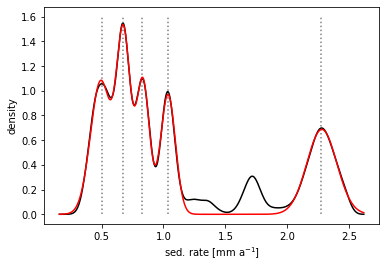

In [7]:
# do a five Gaussian fit to the data

miny = 0
maxy = 1.6
    
plt.plot(dens_all['x'], dens_all['y'],'k')
for pks in peaks_sig:
    plt.plot([pks,pks],[miny,maxy],':',color = 'gray')

h=[]
for pks in peaks_sig:
    idx = np.argmin(abs(dens_all['x'] - pks))
    h.append(dens_all['y'].iloc[idx])
w = [0.2] * len(h)

def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

init_guess = []
for i in np.arange(len(h)):
    init_guess += [peaks_sig[i],h[i],w[i]]

popt, pcov = optimize.curve_fit(func, dens_all['x'], dens_all['y'], p0=init_guess)
fit = func(dens_all['x'], *popt)

plt.plot(dens_all['x'],fit,'r')
plt.ylabel('density')
plt.xlabel('sed. rate [mm a$^{-1}$]')
ctr = popt[np.arange(0,len(popt),3)]
amp = popt[np.arange(1,len(popt),3)]
sd = popt[np.arange(2,len(popt),3)]
print(ctr) # Gaussian mean
print(sd) # one sigma of the Gaussian
print(amp) # amplitude of Gaussian


## And finally let's calculate the age of Mercer Subglacial Lakes

We'll draw from the thickness distrubtion and the highest amplitude Gaussian

In [8]:
thickness_distrib = np.loadtxt('../data/cores/spectral_analysis/thickness_distribution.txt')

n_iter = 1000000 # sample a thickness and a sedimentation rate 1,000,000 times
age = []
age_sd = []
for i,gbg in enumerate(ctr):
    drawn_sed_rates = np.random.normal(loc = ctr[i], scale = sd[i], size = n_iter)
    drawn_thicknesses = np.random.choice(thickness_distrib, size = n_iter)
    slm_ages = drawn_thicknesses/drawn_sed_rates
    age.append(np.mean(slm_ages))
    age_sd.append(np.std(slm_ages))
 
print('preferred slm age: ' + str(age[1]) + ' ± ' + str(age_sd[1]) + ' years.')
print('slm age range: ' + str(min(age)) + ' to ' + str(max(age)) + ' years.')


preferred slm age: 179.38922846998372 ± 21.97380878230442 years.
slm age range: 52.907837795600074 to 259.8202041895506 years.


## Let's plot Figure 3

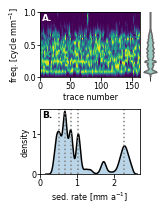

In [9]:
##### FIGURE 3 -  PLOT AS A TWO ROW FIGURE, 1 COLUMN WIDTH

# make rectangles to define your subplots
bottom1 = 0.05
bottom2 = 0.65
height = 0.4

width = 0.62
viol_width = 0.1
left = 0.15

left_freq = left 
left_viol = left + width + 0.01
left_rate = left


rect1 = [left_freq, bottom2, width, height]
rect2 = [left_viol, bottom2, viol_width, height]
rect3 = [left_rate, bottom1, width, height]

# make the surface of sedimentation rates
tmpout = pygmt.surface(x = dens['z']-1, y = dens['x']/1000, z = dens['y'], spacing = '1/0.001', region = [0,164,0,1.5])

with plt.rc_context({"axes.labelsize": 8, 
                     "xtick.labelsize": 8, "ytick.labelsize": 8,
                     'xtick.major.pad': 1, 'ytick.major.pad': 0, 
                     'axes.labelpad': 2}):
    fig = plt.figure(1, figsize = (2.25,2.25), facecolor='white')
    ax2 = plt.axes(rect1)
    ax3 = plt.axes(rect2)
    ax4 = plt.axes(rect3)


    #### plot panel A. - sed freq. heatmap + violin plot
    tmpout.plot(ax = ax2, vmin = 0,vmax = 1, add_colorbar=False)
    ax2.set_xlim([0,164])
    ax2.set_ylim([0,1])
    ax2.set_xticks([0,50,100,150])
    ax2.set_ylabel('freq. [cycle mm$^{-1}$]')
    ax2.set_xlabel('trace number')
    #######


    ###### plot the violin plot next to the figure
    sns.violinplot(y = new_freq['freq']/1000, ax = ax3, inner = None, palette="Set3")
    ax3.set_ylim([0,1])
    sns.despine(ax = ax3, left = True, right = True, top = True, bottom = True)
    ax3.set_yticks([])
    ax3.set_ylabel('')

    #### plot panel B. - sedimentation rates
    minx=0.1
    maxx=2.7
    miny = 0
    maxy = 1.6
    ax4.fill_between(dens_all['x'], 0, dens_all['y'], alpha = 0.3)
    ax4.plot(dens_all['x'], dens_all['y'],'k')
    for pks in peaks_sig:
        ax4.plot([pks,pks],[miny,maxy],':',color = 'gray')


    ax4.set_ylim([miny,maxy])
    ax4.set_xlim([minx,maxx])
    ax4.set_xticks([0,1,2])
    ax4.set_ylabel('density')
    ax4.set_xlabel('sed. rate [mm a$^{-1}$]')

    ax2.annotate(xy=(0.02,0.98),text = 'A.', xycoords = 'axes fraction', 
                 va = 'top', fontsize = 9, fontweight = 'bold', color = 'white')
    ax4.annotate(xy=(0.02,0.98),text = 'B.', xycoords = 'axes fraction', 
                 va = 'top', fontsize = 9, fontweight = 'bold')


plt.savefig('siegvent2023-fig3.png', 
            bbox_inches='tight', transparent = False, dpi = 300)
plt.show()

## Plot Figure S2

In [10]:
%%R
d = density(new_freq$freq)

d0 = data.frame(x = c(d$x, rev(d$x)), y=c(d$y, array(0, dim=length(d$x))))

peaks = d$x[seq(1, length(d$x))[which(diff(sign(diff(d$y)))==-2)]+1]
peaks_y = d$y[!is.na(match(d$x, peaks))]

smoother = array(0, dim=length(d$x))

for (i in 1:length(smoother)) {
  location = d$x[i]
  #distance = 1 - (abs(d$x - location) / max(abs(d$x - location)))^0.5
  distance = 1 - (abs(d$x - location) / max(abs(d$x - location)))
  smoother[i] = sum(distance * d$y) / sum(distance)
}

peaks_bg = smoother[!is.na(match(d$x, peaks))]

peaks_sig = peaks[peaks_y > peaks_bg]
sig_y = d$y[!is.na(match(d$x, peaks_sig))]

dens_all = data.frame(x=d$x, y=d$y)


In [11]:
# dump R valiables to python
%R -o dens_all dens_all -n
%R -o peaks_sig peaks_sig -n
%R -o peaks peaks -n
%R -o peaks_y peaks_y -n
%R -o peaks_bg peaks_bg -n

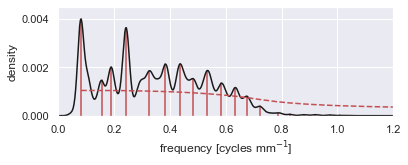

In [12]:
fig = plt.figure(figsize=(6,2), facecolor = 'white')
sns.set_theme()
for i in np.arange(0,len(peaks)):
    plt.plot([peaks[i]/1000,peaks[i]/1000],[0,peaks_y[i]],'r')
plt.plot(dens_all['x']/1000,dens_all['y'],'k')
plt.plot(peaks/1000,peaks_bg,'r--')
plt.ylim([0,0.0045])
plt.xlim([0,1.2])
plt.xlabel('frequency [cycles mm$^{-1}$]')
plt.ylabel('density')
plt.savefig('siegvent2023-figS2.png',bbox_inches='tight', transparent = False, dpi = 300)
plt.show()

## And print out information for Table S1

In [13]:
sed_thickness = 120
df=[]
df = pd.DataFrame({'freq [cycle per mm]': peaks_sig/1000})
df['period [mm]'] = 1/df['freq [cycle per mm]']
df['age given 4 yr fill/drain interval'] = 120/df['period [mm]'] * 4
df['age given 6 yr fill/drain interval'] = 120/df['period [mm]'] * 6
# print a csv that can be copy and pasted into latex
#df.to_csv('table_info.csv', sep = '&', index = False, line_terminator='\\\\\n')
df.round(6)

,freq [cycle per mm],period [mm],age given 4 yr fill/drain interval,age given 6 yr fill/drain interval
0,0.081838,12.219216,39.282390,58.923585
1,0.155694,6.422849,74.733195,112.099793
2,0.189781,5.269218,91.095106,136.642658
3,0.243753,4.102513,117.001463,175.502195
4,0.326131,3.066255,156.542746,234.814120
5,0.382943,2.611355,183.812597,275.718895
6,0.436914,2.288777,209.718955,314.578432
7,0.482364,2.073122,231.534835,347.302252
8,0.533495,1.874431,256.077700,384.116550
9,0.584626,1.710495,280.620566,420.930848
